<table width = "100%">
  <tr style="background-color:white;">
    <!-- QWorld Logo -->
    <td style="text-align:left;width:200px;"> 
        <a href="https://qworld.net/" target="_blank"><img src="../images/QWorld.png"> </a></td>
    <td style="text-align:right;vertical-align:bottom;font-size:16px;"> 
        Prepared by <a href="https://gitlab.com/AkashNarayanan" target="_blank"> AkashNarayanan B</a> and <a href="https://gitlab.com/pjr1363" target="_blank"> Paul Joseph Robin </a></td>    
</table>
<hr>

# BQM Formulation of the Graph Coloring Problem

Let us briefly recall the mathematical model of the graph coloring problem. Given a graph we need to ensure each vertex is so colored that the adjacent vertices have a different color from the set of $K$ colors.

## Decision Variable

$
x_{i,p} = \begin{cases}
  1, & \text{if node} \ i\ \text{is colored}\ p \\
  0, & \text{otherwise}
\end{cases}
$

where $i$ represents the node and $p$ represents the color.


## Constraint 1

Each node is colored only once: 

$
\quad \sum_{p=1}^{K} x_{i,p} = 1 \;\;\;\;\;  i=1,...,N
$

Each node should be colored only once.

$
\sum_{p=1}^{K} x_{i,p} = 1 \quad \forall  i=1,...,N
$

### Equivalent Penalty

$
\quad\quad P\sum_{i=1}^{N} \left(1-\sum_{p=1}^{K}x_{i,p}\right)^2
$

## Constraint 2

Adjacent nodes are differently colored
$
\quad x_{i,p} + x_{j,p} \leq 1 \;\;\;\;\;  p=1,...,K
$

### Equivalent Penalty

$
\quad\quad P\sum_{(i,j) \in E} \sum_{p=1}^{K} x_{i,p}x_{j,p}
$

## QUBO

Therefore, the objective function with a sufficiently large penalty $P$ is,
$$O(x)=P\sum_{i=1}^{N} \left(1-\sum_{p=1}^{K}x_{i,p}\right)^2 + P\sum_{(i,j) \in E} \sum_{p=1}^{K} x_{i,p}x_{j,p}$$

# Imports

In [1]:
from collections import defaultdict

import dimod
import dwave_networkx as dnx
import neal
import networkx as nx

import bqm_utils

# 3-Coloring

Consider this graph with five nodes which was [introduced](QUBO_Examples_GraphColoring_Solutions#task3) in the Graph Coloring notebook. 

<img src="../images/gc_1.png" width="300">

Determine a feasible coloring using $K=3$ colors. 

> **Hint**
> 
> Let $p=1$: <font style="color:orange">Yellow</font>, $p=2$: <font style="color:green">Green</font>, and $p=3$: <font style="color:blue">Blue</font>.
> 

Let us create the above graph using NetworkX and try to solve it by using the in-built function available in dwave_networkx package as well as try to solve it from scratch.

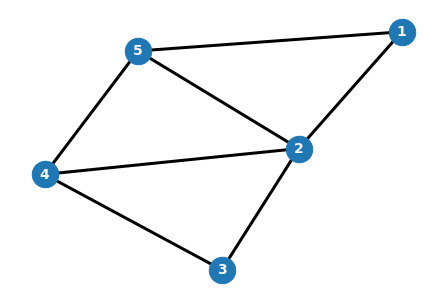

In [2]:
G = nx.Graph()
edges = [(1, 2), (1, 5), (2, 5), (2, 4), (2, 3), (3, 4), (4, 5)]
G.add_edges_from(edges)
bqm_utils.graph_viz(G)

<div class="alert alert-block alert-warning">
<b>Note:</b> The networkx package is designed for analyzing graphs, rather than plotting them.
    So even if the graph does not look the same as you intended, just ensure that the edges are connected properly.
</div>

# Data

In [3]:
# colors = [0, 1, 2]
colors = [1, 2, 3]

# Built-in Function

## `vertex_color()`

In [4]:
sampler = neal.SimulatedAnnealingSampler()
coloring = dnx.vertex_color(G, colors, sampler)
print(coloring)

{1: 3, 2: 1, 3: 2, 4: 3, 5: 2}


## Verification

In [5]:
dnx.is_vertex_coloring(G, coloring)

True

## Visualizing the Result

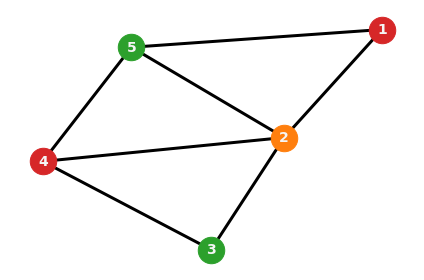

In [6]:
bqm_utils.graph_coloring_viz(G, coloring)

## Task 1 (Optional)

Code a function to visualize the coloring obtained from a sampler.

In [7]:
def viz():
    # Enter your code here
    
    
    
    pass

# Formulating BQM from Scratch

## Step - 1: Define an empty BQM

In [8]:
bqm = dimod.BinaryQuadraticModel('BINARY')

## Step - 2: Add the Constraints to the BQM

### Constraint 1

A node should be colored only once.

$
\sum_{p=1}^{K} x_{i,p} = 1 \quad \forall  i=1,...,N
$

In [9]:
for i in G.nodes:
    c1 = [(f"x_{i}_{p}", 1) for p in colors]
    bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=1)

### Constraint 2

Adjacent nodes should have different colors.

$
x_{i,p} + x_{j,p} \leq 1 \quad \forall  p=1,...,K
$

## Task 2

Add the second constraint to the BQM.

In [10]:
## Enter your code here

for p in colors:
    for i, j in G.edges:
        c2 = [(f"x_{i}_{p}", 1), (f"x_{j}_{p}", 1)]
        bqm.add_linear_inequality_constraint(
            c2, constant=-1, lagrange_multiplier=1, label=f"c2_{i}_{j}_{p}"
        )

## Step - 3: Solve the BQM using `SimulatedAnnealingSampler`

In [11]:
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
print(sampleset.truncate(10))

  slack_c2_1_2_1_0 slack_c2_1_2_2_0 slack_c2_1_2_3_0 ... x_5_3 energy num_oc.
0                0                1                0 ...     0    0.0       1
1                1                0                0 ...     0    0.0       1
2                1                0                0 ...     0    0.0       1
3                0                0                1 ...     1    0.0       1
4                0                0                1 ...     1    0.0       1
5                0                0                1 ...     1    0.0       1
6                0                1                0 ...     0    0.0       1
7                1                0                0 ...     0    0.0       1
8                0                0                1 ...     1    0.0       1
9                1                0                0 ...     0    0.0       1
['BINARY', 10 rows, 10 samples, 36 variables]


## Step - 4: Interpret and check the feasibility of the samples in the sampleset and find the optimum sample

## Task 3

Code a function to interpret the sample as a coloring for the graph.

In [12]:
def find_coloring():
    # Enter your code here
    
    
    
    pass

In [13]:
first_sample = sampleset.first.sample

In [14]:
def find_coloring(G, colors, sample):
    coloring = defaultdict(list)
    for i in G.nodes:
        for p in colors:
            if sample[f"x_{i}_{p}"] == 1:
                coloring[i].append(p)
    return coloring

In [15]:
coloring = find_coloring(G, colors, first_sample)
coloring

# print("Node\tColor")
# print("----\t-----")
# for node, color in coloring.items():
#     print(f"{node}\t{color}")

defaultdict(list, {1: [1], 2: [3], 5: [2], 4: [1], 3: [2]})

## Task 4

Code a function to verify if a given coloring is a feasible coloring or not.

In [16]:
def feasible_coloring():
    # Enter your code here
    
    
    
    pass

In [17]:
def feasible_coloring(G, coloring):
    for node, color in coloring.items():
        if len(color) != 1:
            return False
    
    for i, j in G.edges():
        if coloring[i] == coloring[j]:
            return False        
    return True

In [18]:
def find_best_soln(G, colors, sampleset):
    for sample, energy in sampleset.data(fields=["sample", "energy"]):
        coloring = find_coloring(G, colors, sample)
        if feasible_coloring(G, coloring):
            return energy, coloring

In [19]:
lowest_energy, coloring = find_best_soln(G, colors, sampleset)

print(
    f"Best Solution:\n"
    f"--------------\n"
    f"Energy = {lowest_energy}\n"
    f"Coloring = {dict(coloring)}"
)

Best Solution:
--------------
Energy = 0.0
Coloring = {1: [1], 2: [3], 5: [2], 4: [1], 3: [2]}


## Step - 5: Visualize the Output

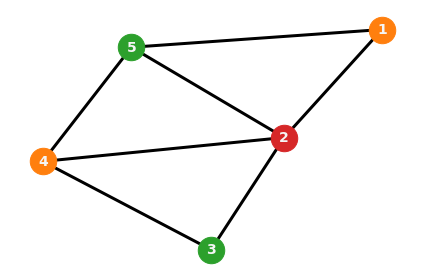

In [20]:
bqm_utils.graph_coloring_viz(G, coloring)

# Minimum Vertex Coloring


$
x_{i,p} = \begin{cases}
  1, & \text{if node i is colored p} \\
  0, & \text{otherwise}
\end{cases}
$

## Objective

Minimize the number of colors used for coloring the graph.

$
\min \sum_{p=1}^{K} c_p
$

## Constraint 1

A node should be colored only once.

$
\sum_{p=1}^{K} x_{i,p} = 1 \quad \forall  i=1,...,N
$

## Constraint 2

Adjacent nodes should have different colors.

$
x_{i,p} + x_{j,p} \leq 1 \quad \forall  p=1,...,K
$

## Constraint 3


$
x_{i,p} \leq c_p \quad \forall  i=1,...,N, \forall  p=1,...,K
$

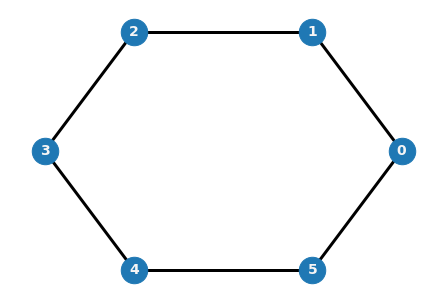

In [21]:
G = nx.cycle_graph(6)
bqm_utils.graph_viz(G)

# Built-in Function

## `min_vertex_color()`

In [22]:
sampler = neal.SimulatedAnnealingSampler()
coloring = dnx.min_vertex_color(G, sampler)
print(coloring)

{0: 0, 1: 1, 2: 0, 3: 1, 4: 0, 5: 1}


## Verification

In [23]:
dnx.is_vertex_coloring(G, coloring)

True

## Visualizing the Result

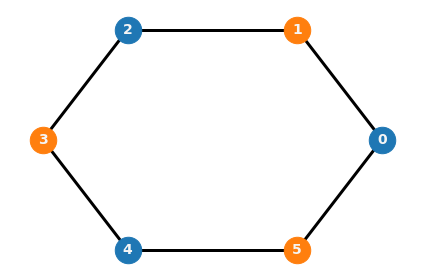

In [24]:
bqm_utils.graph_coloring_viz(G, coloring)

# Formulating BQM from Scratch

In [25]:
def min_vertex_coloring_bqm(G):
    bqm = dimod.BinaryQuadraticModel("BINARY")

    # Objective
    for p in colors:
        bqm.add_linear(f"c_{p}", 1)

    # Constraint 1
    for i in G.nodes:
        c1 = [(f"x_{i}_{p}", 1) for p in colors]
        bqm.add_linear_equality_constraint(c1, constant=-1, lagrange_multiplier=1)

    # Constraint 2
    for p in colors:
        for i, j in G.edges:
            c2 = [(f"x_{i}_{p}", 1), (f"x_{j}_{p}", 1)]
            bqm.add_linear_inequality_constraint(
                c2, constant=-1, lagrange_multiplier=1, label=f"c2_{i}_{j}_{p}"
            )

    # Constraint 3
    for i in G.nodes:
        for p in colors:
            c3 = [(f"x_{i}_{p}", 1), (f"c_{p}", -1)]
            bqm.add_linear_inequality_constraint(
                c3, constant=0, lagrange_multiplier=1, label=f"c3_{i}_{p}"
            )

    return bqm

In [26]:
bqm = min_vertex_coloring_bqm(G)
bqm.shape

(57, 126)

## Solve the BQM using `SimulatedAnnealingSampler`

In [27]:
sampler = neal.SimulatedAnnealingSampler()
sampleset = sampler.sample(bqm, num_reads=100)
print(sampleset.truncate(10))

  c_0 c_1 c_2 slack_c2_0_1_0_0 slack_c2_0_1_1_0 ... x_5_2 energy num_oc.
0   1   1   0                0                0 ...     0    2.0       1
1   1   0   1                0                1 ...     0    2.0       1
2   1   1   0                0                0 ...     0    2.0       1
3   1   0   1                0                1 ...     1    2.0       1
4   1   1   0                0                0 ...     0    2.0       1
5   1   1   0                0                0 ...     0    2.0       1
6   1   1   0                0                0 ...     0    2.0       1
7   0   1   1                1                0 ...     1    2.0       1
8   1   1   0                0                0 ...     0    2.0       1
9   1   0   1                0                1 ...     1    2.0       1
['BINARY', 10 rows, 10 samples, 57 variables]


In [28]:
first_sample = sampleset.first.sample
coloring = find_coloring(G, colors, first_sample)
coloring

defaultdict(list, {0: [0], 1: [1], 2: [0], 3: [1], 4: [0], 5: [1]})

In [29]:
feasible_coloring(G, coloring)

True

In [30]:
lowest_energy, coloring = find_best_soln(G, colors, sampleset)

print(
    f"Best Solution:\n"
    f"--------------\n"
    f"Energy = {lowest_energy}\n"
    f"Coloring = {dict(coloring)}"
)

Best Solution:
--------------
Energy = 2.0
Coloring = {0: [0], 1: [1], 2: [0], 3: [1], 4: [0], 5: [1]}


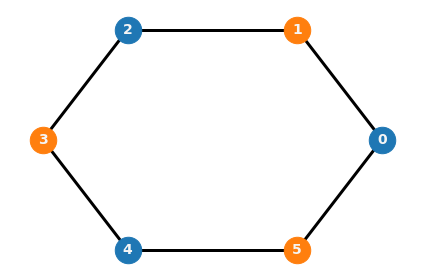

In [31]:
bqm_utils.graph_coloring_viz(G, coloring)

# References

1. F. Glover, G. Kochenberger and Y. Du. "Quantum Bridge Analytics I: A Tutorial on Formulating and Using QUBO Models," [arXiv:1811.11538v6](https://arxiv.org/abs/1811.11538v6), 2019.

2. ["Graph Coloring"](https://github.com/dwave-examples/graph-coloring),  D-Wave Systems Examples, accessed December 2021.

3. ["Map Coloring"](https://github.com/dwave-examples/map-coloring),  D-Wave Systems Examples, accessed December 2021.